In [119]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [120]:
fishes = 12

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

The algorithm automatically sets the number of clusters, instead of relying on a parameter bandwidth, which dictates the size of the region to search through. This parameter can be set manually, but can be estimated using the provided estimate_bandwidth function, which is called if the bandwidth is not set.

The algorithm is not highly scalable, as it requires multiple nearest neighbor searches during the execution of the algorithm. The algorithm is guaranteed to converge, however the algorithm will stop iterating when the change in centroids is small.

Labelling a new sample is performed by finding the nearest centroid for a given sample.

In [121]:
from sklearn.cluster import MeanShift
import sklearn.cluster as cluster
import sklearn.metrics as mt
import random

class MeanShiftFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    def __init__(self):
        self.clustermodel = cluster.MeanShift(bandwidth=2, bin_seeding=True, max_iter=1)
        self.clusters = {}
        
    def choose_action(self, view: np.ndarray):
        # Return speed and turn from view
        param = np.random.randint(5, 51)
        speed = np.random.random() * param
        
        # step 1: try to find a cluster to make a friendship
        action = self.predict_action(view)
        return action[0][0], action[0][1]
    
    def predict_action(self, view: np.ndarray):
        clustermodel = self.clustermodel
        clusters = self.clusters
        
        #clustermodel.predict([view]) returns the index for list clustermodel.cluster_centers_
        prediction = clustermodel.cluster_centers_[clustermodel.predict([view])][0]
        #print(prediction)
        #return np.random.choice(clusters[str(prediction)])
        choice = random.sample(list(clusters[str(prediction)]), 1)
        #print(choice)
        #print("\n\n new new")
        return choice
    
    def train(self, dset):
        clustermodel = self.clustermodel
        clusters = self.clusters
        
        actions = dset[:]["actions"]
        views = dset[:]["views"]
        
        #Train 
        clustermodel.fit(views)
        
        #collect clustercenters as dictionary
        for center in clustermodel.cluster_centers_:
            clusters[str(center)] = []
        
        #assign data to clustercenters
        for point in dset:
            prediction = clustermodel.cluster_centers_[clustermodel.predict([point["views"]])][0]
            clusters[str(prediction)] += [point["actions"]]
        
    
model = MeanShiftFishModel()

In [122]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [123]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating views from 1 files.


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

Created IoDataset:
Reduced the first 3 dimensions from (1, 2, 8989) to (17978)
poses	(17978, 3):	consisting of x, y, calc_ori_rad.
actions	(17976, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(17976, 9):	4 fish_bins and 5 wall ray casts.



In [124]:
model.train(dset)

In [125]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=1000)

100%|██████████| 999/999 [00:21<00:00, 47.42it/s]


In [126]:

f = generator.as_io_file(track)
f.save_as("output/mean_shift.hdf5")

<HDF5 file "534ea232-32fe-4987-90d6-d992f5e01ef6" (mode r+)>

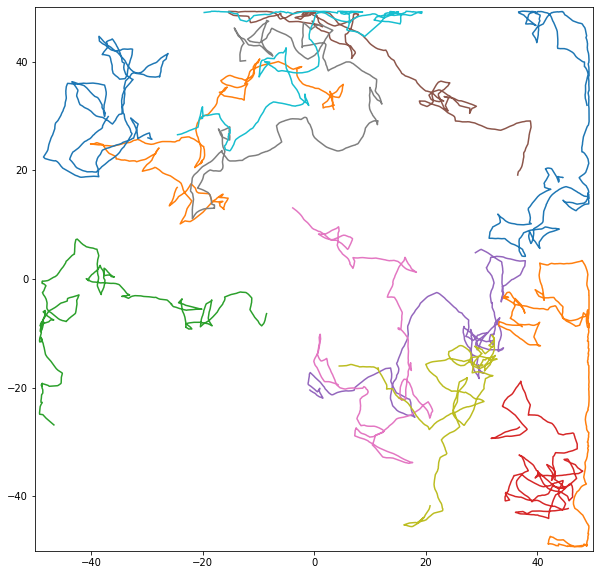

In [127]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()